# NLE Assignment 2: Distributional Semantics

In this assignment, you will be investigating the *distributional hypothesis*: **words which appear in similar contexts tend to have similar meanings**.

For assessment, you are expected to complete and submit this notebook file. When answers require code, you may import and use library functions (unless explicitly told otherwise). All of your own code should be included in the notebook rather than imported from elsewhere. Written answers should also be included in the notebook. You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers. If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data. In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell. Otherwise do not change the code in these cells.

In [82]:
candidateno=215732 #this MUST be updated to your candidate number so that you get a unique data sample

In [83]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/University/Year 2/NLE Notebooks/resources/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [84]:
#do not change the code in this cell
#preliminary imports

import re
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet_ic')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
brown_ic = wn_ic.ic("ic-brown.dat")


from sussex_nltk.corpus_readers import ReutersCorpusReader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


We are going to be using the Reuters corpus of financial documents for this assignment.  When you run the following cell you should see that it contains 1,113,359 sentences.

In [85]:
#do not change the code in this cell
rcr = ReutersCorpusReader().finance()
rcr.enumerate_sents()

1113359

The following cell will take 2-5 minutes to run.  It will generate a unique-to-you sample of 200,000 sentences.  These sentences are tokenised and normalised for case and number for you.

In [86]:
#do not change the code in this cell
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

random.seed(candidateno)  
samplesize=2000
iterations =100
sentences=[]
for i in range(0,iterations):
    sentences+=[normalise(sent) for sent in rcr.sample_sents(samplesize=samplesize)]
    print("Completed {}%".format(i))
print("Completed 100%")


Completed 0%
Completed 1%
Completed 2%
Completed 3%
Completed 4%
Completed 5%
Completed 6%
Completed 7%
Completed 8%
Completed 9%
Completed 10%
Completed 11%
Completed 12%
Completed 13%
Completed 14%
Completed 15%
Completed 16%
Completed 17%
Completed 18%
Completed 19%
Completed 20%
Completed 21%
Completed 22%
Completed 23%
Completed 24%
Completed 25%
Completed 26%
Completed 27%
Completed 28%
Completed 29%
Completed 30%
Completed 31%
Completed 32%
Completed 33%
Completed 34%
Completed 35%
Completed 36%
Completed 37%
Completed 38%
Completed 39%
Completed 40%
Completed 41%
Completed 42%
Completed 43%
Completed 44%
Completed 45%
Completed 46%
Completed 47%
Completed 48%
Completed 49%
Completed 50%
Completed 51%
Completed 52%
Completed 53%
Completed 54%
Completed 55%
Completed 56%
Completed 57%
Completed 58%
Completed 59%
Completed 60%
Completed 61%
Completed 62%
Completed 63%
Completed 64%
Completed 65%
Completed 66%
Completed 67%
Completed 68%
Completed 69%
Completed 70%
Completed 71%
Co

`generate_features()` will used in the first part of the assignment.

In [87]:
#do not change the code in this cell
#generate features method as applied in multiple labs and later also in part 4 of the assignment (Vector class)
def generate_features(sentences,window=1): 
    mydict = {}
    for sentence in sentences:
        for i,token in enumerate(sentence):
            current=mydict.get(token,{})
            features=sentence[max(0,i-window):i]+sentence[i+1:i+window+1]
            for feature in features:
                current[feature]=current.get(feature,0)+1
            mydict[token]=current
    return mydict

1) Run `generate_features(sentences[:5])`. With reference to the code and the specific examples, explain how the output was generated [10 marks]

In [88]:
generate_features(sentences[:5]) #generate features example

{"'s": {'commission': 1, 'competition': 1},
 ',': {'agreeing': 1, 'merger': 1},
 '.': {'competition': 1, 'no': 1, 'reasons': 1},
 'NUM': {'NUM': 6, 'demand': 1, 'european': 1, 'index': 1, 'the': 1},
 'a': {'committee': 1},
 'administration': {'demand': 1, 'state': 1},
 'advised': {'states': 1, 'the': 1},
 'again': {'said': 1, 'thursday': 1},
 'agreeing': {',': 1, 'with': 1},
 'all': {'share': 1},
 'and': {'not': 1, 'regulations': 1},
 'antitrust': {'european': 1, 'experts': 1},
 'block': {'the': 1, 'to': 1},
 'boeing': {'had': 1, 'that': 1},
 'case': {'the': 1, 'under': 1},
 'commission': {"'s": 1, 'on': 1, 'the': 2},
 'commissioner': {'competition': 1, 'karel': 1},
 'committee': {'a': 1, 'of': 1},
 'competition': {"'s": 1,
  '.': 1,
  'commissioner': 1,
  'eu': 1,
  'services': 1,
  'threaten': 1},
 'concerns': {'its': 1, 'that': 1},
 'deal': {'the': 1, 'would': 1},
 'demand': {'NUM': 1, 'administration': 1},
 'eu': {'competition': 1, 'had': 1, 'the': 1},
 'european': {'NUM': 1, 'anti

1)
The function generate_features returns mydict after running through sentences in our corpus and links together tokens with given word features. In the line above we rant generate_features with reference to sentences from an index 0 to index 5 (excluding 5). By looking at the output of the cell above, we can easily identify which token has which features. Most of the time these features, are words or other syntactical signs that are linked specifically to the given word. These words are within the same context of certain under words (features) and thus contribute to the meaning of the corpus.

To get the specific output shown in the cell above we first need to iterate through the sentence in index 0 to sentence in index 5 (excluding 5). From there different assignments are used in the generate_features to first iterate through the sentences in the corpus. Then the sentence and window specifications are assigned to the variable features. Then another for loop iterates through features, assigning a value to each given feature. Current is then reassigned to mydict and then returned. This process can be seen in the cell above where the number 1 can be found after each feature and describes how often it appears in context with a given word.

Features can be anything from a "NUM" to a determiner to any given part of speech. This becomes clear in the output. The output can also be easily used to further invesitgate our corpus and gives insights into the meaning of words and the possible connection/context of a given word.

2) Write code and **find** the 1000 most frequently occurring words that
* are in your sample; AND
* have at least one noun sense according to WordNet [10 marks]

In [89]:
#Question 2

import operator #operator import for use in most_freq function
#Applying code from week 7 and reworking most_freq function - additional measures to identify at least one noun sense
def freq_distri(sentences):
    mydict={} #Creation of dictionary
    for sentence in sentences: #Looping through sentences - as done many times before - e.g. assingment 1 and labs
        for (token) in sentence:    
            mydict[token]=mydict.get(token,0)+1
    return mydict

#Also applied from labs - using similar means to identify the most frequent words and how often they appear
def most_freq(freqdist,k=1000): #arguments used from labs but edited to fit freqeuncy list size
    sorted_frequency = sorted(freqdist.items(), key=operator.itemgetter(1),reverse=True)
    noun_senses = [] #slight change in lab implemtation - list of tuples is used to represent and print the most frequent words
    for tupleA in sorted_frequency: #going through sorted frequency
      if len(wn.synsets(tupleA[0], wn.NOUN)) > 0: #considers if any given word has a noun sense if so, it is appended to the list created above
        noun_senses.append(tupleA)
        tuple_edit = noun_senses[:k] #Going all the way through the list until we reach the position of k - 1000

    return tuple_edit

mostfreq_1000 = most_freq(freq_distri(sentences))  # reassigning value and applying the function to the freq_distri function
print(mostfreq_1000)#print
print(len(mostfreq_1000))#additional print to check if proper length is still there

[('in', 55898), ('a', 48745), ('percent', 18046), ('it', 15307), ('be', 14733), ('pct', 14327), ('at', 13772), ('was', 13400), ('he', 11078), ('will', 11004), ('as', 10832), ('bank', 9124), ('million', 8940), ('year', 8724), ('have', 8572), ('may', 8527), ('are', 8525), ('has', 8515), ('its', 8382), ('government', 8179), ('an', 8116), ('billion', 7220), ('uk', 5778), ('tax', 5691), ('rate', 5645), ('trade', 5431), ('budget', 4913), ('more', 4763), ('growth', 4732), ('last', 4643), ('u.s.', 4618), ('first', 4401), ('price', 4104), ('central', 4104), ('market', 4088), ('june', 3993), ('newsroom', 3957), ('there', 3946), ('state', 3888), ('over', 3860), ('inflation', 3797), ('or', 3790), ('union', 3771), ('bonds', 3704), ('minister', 3521), ('one', 3511), ('rates', 3486), ('no', 3473), ('economy', 3434), ('prices', 3362), ('week', 3292), ('april', 3286), ('can', 3257), ('two', 3219), ('i', 3202), ('interest', 3198), ('currency', 3176), ('finance', 3164), ('gdp', 3056), ('deficit', 2954), 

3) Consider the code below which outputs the path similarity score, the Resnik similarity score and the Lin similarity score for a pair of concepts in WordNet.  Answer the following questions.

a) Explain what each of the numbers in the output means.

b) Write code to find the semantic similarity of a pair of words according to WordNet with a parameter to specify the measure of semantic similarity between concepts.  Explain and justify the strategy used for words which have multiple senses.

c) Choose one of the measures of semantic similarity and then for every possible pair of words identified in Q2, determine the semantic similarity of the pair according to WordNet.  Justify your choice of semantic similarity measure.

d) Identify the 10 most similar words (according to WordNet) to the most frequent word in the corpus [20 marks]

In [90]:
#do not change the code in this cell.  It relates to Q3
wordpair=("house","garden")
concept_1=wn.synsets(wordpair[0])[0]
concept_2=wn.synsets(wordpair[1])[0]
print("Path similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.path_similarity(concept_1,concept_2)))
print("Resnik similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.res_similarity(concept_1,concept_2, brown_ic)))
print("Lin similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.lin_similarity(concept_1,concept_2, brown_ic)))

Path similarity between 1st sense of house and 1st sense of garden is 0.08333333333333333
Resnik similarity between 1st sense of house and 1st sense of garden is 1.2900256809649917
Lin similarity between 1st sense of house and 1st sense of garden is 0.15380807721262396


3a)

Path similarity represents the distance between two concepts (words) in a tree structure e.g. Thesaurus Hierarchy. If the path between specific concepts is short, it can be assumed that there is a greater similarity between these two concepts. However, if the path between specific concepts is long it may be an indication that there is less of a similarity between the two concepts. Looking at the results of the cell above it becomes clear that the path similarity is quite low, implying that in a possible Thesaurus Hierarchy the 1st sense of house and garden are not close to each other and thus are not similar.

Resnik similarity represents the information content in what the concepts share i.e. their lowest common subsumer. In other words, the more two words have in common the more similar they are. The lowest common subsumer of a relationship x and y is the most specifc concept which is an ancestor to both x and y. Compared to the result from the Path similarity calculations, the Resnik method has a significantly higher results implying a high similarity. This means that some ancestor of the first word sense of garden and house shares similar information content to both given senses(and thus represents an ancestral position).

Lin similarity represents the ratio of shared information content to total information content. Compared to the Resnik method this value is significantly lower implying that the ratio of shared information content to to total information content is low between the first senses of house and garden.

 

In [91]:
#Question 3b)
#Function applied from Week 5 lab - reused for later use in question 3
def word_similarity(wordA,wordB,pos=wn.NOUN,measure="path"): #Setting up arguments 
    synsetsA=wn.synsets(wordA,pos) #Defining sysnsets for later use
    synsetsB=wn.synsets(wordB,pos)
#Use of maxsofar value - returned in the end 
    maxsofar=0
#Looping through synsets - describing actions when various similarity measures are done    
    for synsetA in synsetsA:
        for synsetB in synsetsB:
            if measure=="path":
                sim=wn.path_similarity(synsetA,synsetB)
            elif measure=="res":
                sim=wn.res_similarity(synsetA,synsetB,brown_ic)
            elif measure=="lin":
                sim=wn.lin_similarity(synsetA,synsetB,brown_ic)
            #Relying on information from the brown corpus - imported above
            if sim>maxsofar:
              maxsofar=sim
    return maxsofar


In [92]:
#Path similarity example - using eu and uk words
word_similarity("eu","uk",measure="path")

0.07142857142857142

In [93]:
#Resnik similarity example - using eu and uk words
word_similarity("eu","uk",measure="res")

0.8017591149538994

In [94]:
#Lin similarity example - using eu and uk words
word_similarity("eu","uk",measure="lin")

1.6035182299077988e-300

In [95]:
#Question 3c)
# function required - use of mostfreq_1000 value to go through current known words
def freq_sim1000(frequency_list):
  frequency_sim = [] #creation of a new list to hold the values and compare the specifc tuples
  for tupleA in frequency_list:#tuple applied from most_freq function
    for tupleB in frequency_list:#Second for loop considering the second tuple that is iterated through - simple nested for loop approach
      if tupleA[0] != tupleB[0]: #With this if statement it is ensured that the same words are not compared with each other, as it doesn't portray any meaning
        frequency_sim.append((tupleA[0], tupleB[0],(word_similarity(tupleA[0], tupleB[0], measure='res'))))
        #Using format to have an readable output including the completed pairs and the given words that are compared
        print("Completed {} pairs out of 999000 and the similarity of {} and {} is {}".format(len(frequency_sim),tupleA[0],tupleB[0],frequency_sim[-1][-1]))
  print("You have reached 999000 pairs")

  return frequency_sim    

#sim1000 = freq_sim1000(frequency_sim)     
#print(sim1000)
similarity = freq_sim1000(mostfreq_1000)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Completed 994002 pairs out of 999000 and the similarity of opinion and site is 0
Completed 994003 pairs out of 999000 and the similarity of opinion and offering is 3.8478154212435802
Completed 994004 pairs out of 999000 and the similarity of opinion and telephone is 0
Completed 994005 pairs out of 999000 and the similarity of opinion and spread is 2.3322377550841122
Completed 994006 pairs out of 999000 and the similarity of round and in is 3.33670590680296
Completed 994007 pairs out of 999000 and the similarity of round and a is 3.33670590680296
Completed 994008 pairs out of 999000 and the similarity of round and percent is 0.5962292078977726
Completed 994009 pairs out of 999000 and the similarity of round and it is 3.29228159340886
Completed 994010 pairs out of 999000 and the similarity of round and be is 3.33670590680296
Completed 994011 pairs out of 999000 and the similarity of round and pct is 0.5962292078977726
Com

3c) Justification for similarity measure

The Resnik method was most suitable to investigate the similarity of the 1000 most frequent word, as it represents the information content in what the concepts share i.e. their lowest common subsumer. In other words this means the more two words have in common the more similar they are. This is a more suitable way of looking at the set of words, that other methods as with Lin we would want to have an understanding of the total information content not only the 1000 most frequent words. Path similarity was also a possible option but it seemed more suitable for our current example to understand the lowest common subsumer instead of a given pathlength.



In [96]:
#Question 3d)
#use of slice keyword - which slices a given input into subsets that can be reapplied
#no function requried
slice1000freq = similarity[:999] # calling of similarity value, which was used in 3c) - going up to value 999 to not include the same word in the comparison
sort_slice = sorted(slice1000freq,key=operator.itemgetter(-1),reverse=True) 
mostsim10 = sort_slice[:10] #Slicing once again to identify the 10 most simlar words
print(mostsim10)

[('in', 'a', 6.060679964128936), ('in', 'as', 6.060679964128936), ('in', 'points', 6.060679964128936), ('in', 'point', 6.060679964128936), ('in', 'head', 6.060679964128936), ('in', 'pace', 6.060679964128936), ('in', 'be', 5.442191710437843), ('in', 'eu', 5.442191710437843), ('in', 'na', 5.442191710437843), ('in', 'us', 5.442191710437843)]


4)a) Write code to construct distributional vector representations of words in the corpus with a parameter to specify context size.  Explain how you calculate the value of association between each word and each context feature.

b) Use your code to construct representations of the 1000 words identified in Q2 with a window size of 1 

c) Use your representations to find the 10 words which are distributionally most similar to the most frequent word in the corpus. [15 marks]

In [97]:
#Question 4a)
#dot function applied from Lab 7 - required for the vector class and establishing word represenations
def dot(vecA,vecB):
    the_sum=0
    for (key,value) in vecA.items():
        the_sum+=value*vecB.get(key,0)
    return the_sum


In [98]:
#word_vectors class - applied from lab 7 and generates features in regards to window size to create word representations
class word_vectors:

#init function - initialistes values and other functions  
    def __init__(self,sentences,window=3):
        self.sentences=sentences
        self.window=window
        self.reps={}
        self.wordtotals={}
        self.feattotals={}
        self.generate_features_vector()
        self.grandtotal=sum(self.wordtotals.values())
        self.convert_to_ppmi()

#generate_features_vector function - used to create features for a given window - similar to the one used above   
    def generate_features_vector(self):
        for sentence in self.sentences:
            for i,token in enumerate(sentence):
                current=self.reps.get(token,{})
                features=sentence[max(0,i-self.window):i]+sentence[i+1:i+self.window+1]
                for feature in features:
                    current[feature]=current.get(feature,0)+1
                    self.feattotals[feature]=self.feattotals.get(feature,0)+1
                self.wordtotals[token]=self.wordtotals.get(token,0)+len(features)
                self.reps[token]=current

#convert_to_ppmi function - used for ppmi calculations once we have used pmi
#includes specific calculations necessary
    def convert_to_ppmi(self):
        self.ppmi={word:{feat:max(0,math.log((freq*self.grandtotal)/(self.wordtotals[word]*self.feattotals[feat]),2)) for (feat,freq) in rep.items()} for (word,rep) in self.reps.items()}

#similarity function - comapres two words and identifies similarity via ppmi        
    def similarity(self,word1,word2):
        rep1=self.ppmi.get(word1,{})
        rep2=self.ppmi.get(word2,{})
        return dot(rep1,rep2)/math.sqrt(dot(rep1,rep1)*dot(rep2,rep2))

#nearest_neighbours function - identifies nearest neighbor of a given word in the corpus by applying similarity function above  
#important function as it calls upon the similarity function and thus on the ppmi function - making it useful for part 4c)  
    def nearest_neighbours(self,word1,n=1000,k=10):
        candidates=sorted(self.wordtotals.items(),key=operator.itemgetter(1),reverse=True)[:n]
        sims=[(word1,cand,self.similarity(word1,cand)) for (cand,_) in candidates]
        return sorted(sims,key=operator.itemgetter(2),reverse=True)[:k]

4a)
Within the generate features function the value of association between each word and each context feature is calculated. The   generate_features function takes a list of sentences (where each sentence is a list of tokens) and a specifc window size as a parameter.

A dictionary of dictionaries is then established to further identify the features of a given word token. The key to the outermost dictionary is a word, while the key to each inner dictionary is a another word. The value in the inner dictionary should be the number of the times the words co-occur together inside the window that was specified.

This specifc calculation can be viewed within these three lines of code:

"current[feature]=current.get(feature,0)+1

 self.feattotals[feature]=self.feattotals.get(feature,0)+1
 
 self.wordtotals[token]=self.wordtotals.get(token,0)+len(features)"




In [99]:
#Question 4b)
#Establishing window size of 1 for the various word representations
vectors_01 = word_vectors(sentences,window=1)

In [100]:
#Example on how Vector class works - identifies nearest neighbour of a given word in the reuters corpus
vectors_01.nearest_neighbours('committee') #word "committee" used to identify nearest neighbours

[('committee', 'committee', 1.0),
 ('committee', 'council', 0.13431750307474527),
 ('committee', 'senate', 0.12766840199528404),
 ('committee', 'board', 0.12609388179698622),
 ('committee', 'department', 0.11603318198673636),
 ('committee', 'house', 0.10775932533073711),
 ('committee', 'cabinet', 0.09727621718101132),
 ('committee', 'commission', 0.09647444047468627),
 ('committee', 'ministry', 0.09296764540039003),
 ('committee', 'agency', 0.07743361390700722)]

In [101]:
#Question 4c) 
#Printing out of ten nearest neighbours of "in" - calling of mostfreq and applying similar technique to committee example above
distr_sim1 = vectors_01.nearest_neighbours(mostfreq_1000[0][0])
print(distr_sim1) #Printing out the 10 words most distributionally similar to the most frequent word in the corpus


[('in', 'in', 1.0), ('in', '.', 0.14860261447035916), ('in', 'and', 0.1383992639613707), ('in', 'of', 0.1243643489600894), ('in', ',', 0.1194081628245531), ('in', 'from', 0.1165758246689025), ('in', 'on', 0.11287242506154102), ('in', 'for', 0.10901144148386772), ('in', 'by', 0.10241108120854263), ('in', 'was', 0.10021906227323213)]


5) Plan and carry out an investigation into the correlation between semantic similarity according to WordNet and distributional similarity with different context window sizes. You should make sure that you include a graph of how correlation varies with context window size and that you discuss your results. [25 marks]

Question 5

Before we start our investigation it is valuable to define the concepts that will be analysed. Semantic similarity refers to relationships that are closely linked together by meaning, which can be primarily be represented within order or by taxological means, which shows the distance between two concepts. One example of this is the idea of Path similarity which was used in this coursework in question 2 and 3. 

Distributional similarity on the other hand refers specifically to the context of given words and investigates the words that are in close proximity. The process of using vectors (assigning specifc values to the context of a word) is especially important, which can be seen in the vector class above, where we rely on the ppmi function to identify similarity and eventually the nearest neighbour of a given word.

With these two concepts defined we can now properly investigate the methods at hand.


In [102]:
#Question 5 
#Setting up a simple table to represent the top 10 most semantically similar words - as used in question 3d
#The following three tables represent a window size of 1 
df=pd.DataFrame(mostsim10,columns=["word1","word2","Semantic similarity"])
df


,word1,word2,Semantic similarity
0,in,a,6.060680
1,in,as,6.060680
2,in,points,6.060680
3,in,point,6.060680
4,in,head,6.060680
5,in,pace,6.060680
6,in,be,5.442192
7,in,eu,5.442192
8,in,na,5.442192
9,in,us,5.442192


In [103]:
#Additional table to represent semantic similarity with the given methods - Path, Res and Lin similarity
#Applied from lab class 
measures=["path","res","lin"]
for measure in measures:
    scores=[]
#Representing the data and appending of scores
    for triple in mostsim10:
        scores.append(word_similarity(triple[0],triple[1],measure=measure))
    df[measure]=scores   
df

,word1,word2,Semantic similarity,path,res,lin
0,in,a,6.060680,0.250000,6.060680,0.387551
1,in,as,6.060680,0.250000,6.060680,0.387551
2,in,points,6.060680,0.333333,6.060680,0.689171
3,in,point,6.060680,0.333333,6.060680,0.689171
4,in,head,6.060680,0.333333,6.060680,0.688572
5,in,pace,6.060680,0.333333,6.060680,0.648730
6,in,be,5.442192,0.333333,5.442192,0.596517
7,in,eu,5.442192,0.333333,5.442192,0.063246
8,in,na,5.442192,0.333333,5.442192,0.428927
9,in,us,5.442192,0.333333,5.442192,0.514258


In [104]:
#Third table representing table for Distributional similarity
#Calling vector value
df=pd.DataFrame(distr_sim1,columns=["word1","word2","Distributional similarity"])
df

,word1,word2,Distributional similarity
0,in,in,1.000000
1,in,.,0.148603
2,in,and,0.138399
3,in,of,0.124364
4,in,",",0.119408
5,in,from,0.116576
6,in,on,0.112872
7,in,for,0.109011
8,in,by,0.102411
9,in,was,0.100219


These 3 tables are a visualisation of the data shown in question 4. 

Next 5 scatter plots are created to further investigate the relationship of the two similarity methods. Various window sizes are used to identify different relationships between the set of words. The window sizes are important to consider as if we have increase the window size we potentially increase the number of words that might have an impact on the given meaning of a word. This is important to the investigation as it can then be deduced how much the window size impacts the varying semantic and distrubionaly similarity methods.

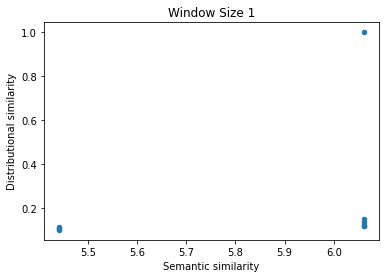

In [105]:
#Scatter plot for window size 1 between Semantic and Distributional Similarity
#Setting up new vector value and window size - similar to question 4
vectors_01 = word_vectors(sentences,window=1)
distr_sim1 = vectors_01.nearest_neighbours(mostfreq_1000[0][0])
#Setting up data frame to reaccessing the colums from earlier tables 
df=pd.DataFrame(mostsim10,columns=["word1","word2","Semantic similarity"])
#Use of zip to return an iterator
word1,word2,distr_sim = zip(*distr_sim1)
df["Distributional similarity"] = distr_sim
#Creation of axis and label descriptions
df.plot.scatter("Semantic similarity", "Distributional similarity", title = "Window Size 1")


In [106]:
#Table for Window 1
df=pd.DataFrame(distr_sim1,columns=["word1","word2","Distributional similarity"])
df

,word1,word2,Distributional similarity
0,in,in,1.000000
1,in,.,0.148603
2,in,and,0.138399
3,in,of,0.124364
4,in,",",0.119408
5,in,from,0.116576
6,in,on,0.112872
7,in,for,0.109011
8,in,by,0.102411
9,in,was,0.100219


Observing the first graph it becomes clear that there is no significant corrleation or a given relationship between the two similarity methods. The various words and occurences of the words are spread our and now specifc trend line can be observed. This has multiple indications, such as that the window size does  specifically imapact this investigation, as the different methods simply arrive at different conclusion on the meaning of a given word/corpus. 

When further looking at the table these indications become more clear. This also results in a problem as we can see that in is compared to itself and throughout all following table and does not represent a natural comparison or meaningful similarity.

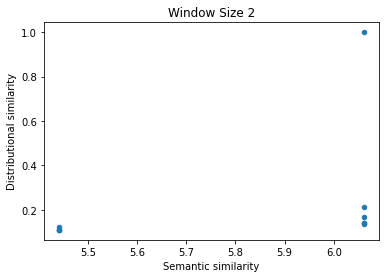

In [107]:
#Scatter plot for window size 2 between Semantic and Distributional Similarity
#Setting up new vector value and window size - similar to question 4
vectors_2 = word_vectors(sentences,window=2)
distr_sim2 = vectors_2.nearest_neighbours(mostfreq_1000[0][0])
#Setting up data frame to reaccessing the colums from earlier tables 
df=pd.DataFrame(mostsim10,columns=["word1","word2","Semantic similarity"])
#Use of zip to return an iterator
word1,word2,distr_sim = zip(*distr_sim2)
df["Distributional similarity"] = distr_sim
#Creation of axis and label descriptions
df.plot.scatter("Semantic similarity", "Distributional similarity", title = "Window Size 2")

In [108]:
#Table for Window 2
df=pd.DataFrame(distr_sim2,columns=["word1","word2","Distributional similarity"])
df

,word1,word2,Distributional similarity
0,in,in,1.000000
1,in,the,0.214329
2,in,a,0.166932
3,in,and,0.141631
4,in,.,0.139626
5,in,of,0.136506
6,in,",",0.122801
7,in,with,0.110818
8,in,from,0.109633
9,in,its,0.109055


Observing the second graph it becomes clear that there is no significant corrleation or a given relationship between the two similarity methods.Compared to the window size of 1 there are slight changes to the composition of the words on the graphs. On the lower right side of the graph certain points move slightly apart, indicating an impact through the window size.

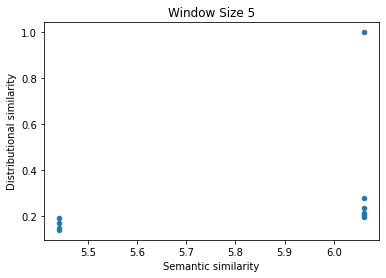

In [109]:
#Scatter plot for window size 5 between Semantic and Distributional Similarity
#Setting up new vector value and window size - similar to question 4
vectors_5 = word_vectors(sentences,window=5)
distr_sim5 = vectors_5.nearest_neighbours(mostfreq_1000[0][0])
#Setting up data frame to reaccessing the colums from earlier tables 
df=pd.DataFrame(mostsim10,columns=["word1","word2","Semantic similarity"])
#Use of zip to return an iterator
word1,word2,distr_sim = zip(*distr_sim5)
df["Distributional similarity"] = distr_sim
#Creation of axis and label descriptions
df.plot.scatter("Semantic similarity", "Distributional similarity", title = "Window Size 5")

In [110]:
#Table for Window 5
df=pd.DataFrame(distr_sim5,columns=["word1","word2","Distributional similarity"])
df

,word1,word2,Distributional similarity
0,in,in,1.000000
1,in,the,0.277444
2,in,a,0.236088
3,in,.,0.210812
4,in,of,0.203120
5,in,and,0.193475
6,in,",",0.192391
7,in,to,0.169644
8,in,said,0.148469
9,in,'s,0.138735


In the third graph there is also no significant corrleation or a given relationship between the two similarity methods. Nonetheless, there are more significant changes in the distribution of the words (represented by points) on the right side of the graph. 

Furthermore there are various changes to the left side of the graph with many points focusing together. This implies that when the semantic similarity is rather low for certain words in the top ten list, these words also tend to be low in similarity for the distributional method.

These changes are still minimal and are mainly related to the right side of the graph.

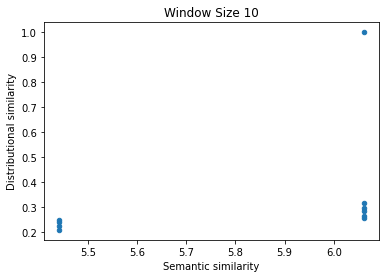

In [111]:
#Scatter plot for window size 10 between Semantic and Distributional Similarity
#Setting up new vector value and window size - similar to question 4
vectors_10 = word_vectors(sentences,window=10)
distr_sim10 = vectors_10.nearest_neighbours(mostfreq_1000[0][0])
#Setting up data frame to reaccessing the colums from earlier tables 
df=pd.DataFrame(mostsim10,columns=["word1","word2","Semantic similarity"])
word1,word2,distr_sim = zip(*distr_sim10)
df["Distributional similarity"] = distr_sim
#Creation of axis and label descriptions
df.plot.scatter("Semantic similarity", "Distributional similarity", title = "Window Size 10")

In [112]:
#Table for Window 10
df=pd.DataFrame(distr_sim10,columns=["word1","word2","Distributional similarity"])
df

,word1,word2,Distributional similarity
0,in,in,1.000000
1,in,the,0.315023
2,in,a,0.294378
3,in,.,0.283784
4,in,of,0.264945
5,in,and,0.254055
6,in,",",0.246150
7,in,said,0.237967
8,in,to,0.222510
9,in,'',0.207267


Again there is no significant corrleation or a given relationship between the two similarity methods. Nonetheless, there are slight changes in the distribution of the words (represented by points) on the right side of the graph. The words on the right side where most changes occur are more tightly bounded together, which implies that semantic distributional similarity becomes more ambiguous due to the large window size.

In [113]:
#Table for Window 100
df=pd.DataFrame(distr_sim100,columns=["word1","word2","Distributional similarity"])
df

,word1,word2,Distributional similarity
0,in,in,1.000000
1,in,the,0.320228
2,in,a,0.312911
3,in,said,0.306510
4,in,and,0.287651
5,in,of,0.277016
6,in,.,0.258014
7,in,'',0.237355
8,in,``,0.234581
9,in,to,0.233642


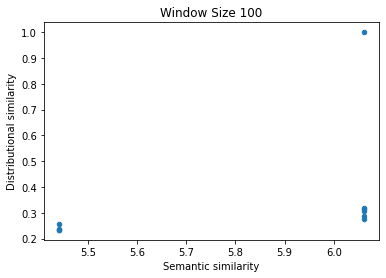

In [114]:
#Scatter plot for window size 100 between Semantic and Distributional Similarity
vectors_100 = word_vectors(sentences,window=100)
distr_sim100 = vectors_100.nearest_neighbours(mostfreq_1000[0][0])
#Setting up data frame to reaccessing the colums from earlier tables 
df=pd.DataFrame(mostsim10,columns=["word1","word2","Semantic similarity"])
#Use of zip to return an iterator
word1,word2,distr_sim = zip(*distr_sim100)
df["Distributional similarity"] = distr_sim
#Creation of axis and label descriptions
df.plot.scatter("Semantic similarity", "Distributional similarity", title = "Window Size 100")

Observing the fith and final graph it becomes clear that there is no significant corrleation or a given relationship between the two similarity methods. The various words and occurences of the words are spread our and now specifc trend line can be observed. Nonetheless, there are again slight changes in the distribution of the words (represented by points) on the right side of the graph. The words are more closely bounded together on the right side, indicating that it is more difficult to identify the meaning of a given text when the window size increases significantly when a distrubutional similarity measure is used.

Furthermore, the developments observed on the right size in the third graph has also moved back, implying that a significantly larger window size also impacts these changes (when some words are low in distributional similarity then they are low in semantic similarity). Some similar relationship can observed in the top right corner throughout all graphs but due to the limited points, it is less significant and might be an outlier.

To further investigate and compare our two similarities, it is worth considering the affect spearmens correlation coeffiecient has on the two data sets. This allows the view of data set through another analytical lense, possibly offering additional interesting results.

In [115]:
#Use of spearmans correlation method (coefficient) to further investigate similarity
df.corr(method='spearman')

,Semantic similarity,Distributional similarity
Semantic similarity,1.000000,0.852803
Distributional similarity,0.852803,1.000000


The table here shows the correlation values, after applying Spearmans method.Spearman's rank correlation coefficient is used instead of Pearson's product-moment correlation coefficient, as the similarity scores are unlikely to be normally distributed.

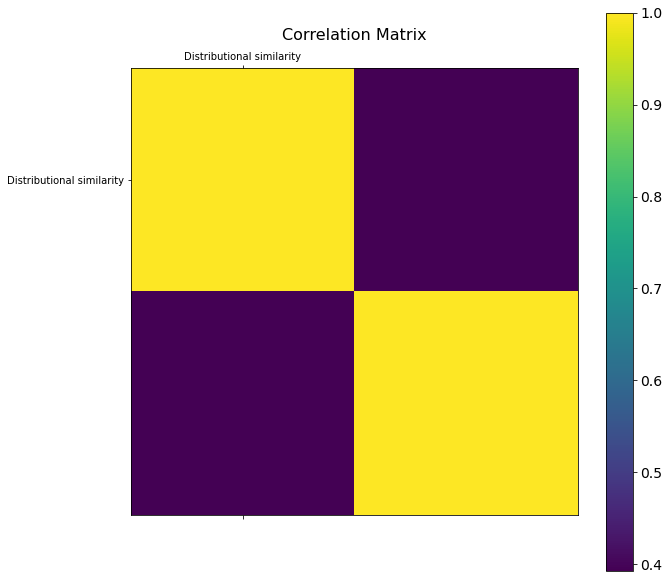

In [116]:
import matplotlib.pyplot as plt
#Use of matplot within pyplot to create graph representing correlation coefficient
#Due to difficulties with pandas this import was applied
#Calling df.corr from the cell above
#Describes size of figure
graph = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=graph.number)
#Description of x and y axis
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
#Addition of colorbar
cb = plt.colorbar()
#Specification of label size
cb.ax.tick_params(labelsize=14)
#Specification of font size
plt.title('Correlation Matrix', fontsize=16);

Looking at the results of the graph visualisation it is clear to see that there is some redundancy in the graph we can ignore. We do not need to consider the correlation between the two similarities themselves. Instead we just need to look at the value 0.852803	indicating a high near perfect association of ranks. We can thus conclude a strong association between the two similarities when using Spearmans method. Using other methods such as pearsons correlation coefficient might lead to different results. Spearmans method views the entire tables used earlier and from there identifies a single correlation value. This was done by employing the window size of 1, indicating that if less words in the context are observed the methods investigated tend to be similar in their approach by following similar patterns.

In conclusion it becomes clear that there is no specifc relationship between the results of the distributional similarity and semantic similarity methods. There are minor changes when the window sizes are changed but no siginificant changes that generate certain implications about the nature of both methods. Generally though it can be argued that when the window size is increased significantly the results between the two methods become less and less signifcant. Within the range of 1 - 10 the window size the results were more prone to changing, implying that within that range change is more likely to occur as the meaning of words in that range can be more easily understood.

Interestingly enought the use of Spearmans correlation method results in a strong association of ranks, which is a surprising result. This could be due to the window size of 1 where some points were more widely spread than with higher window sizes. 

In general there are some things that need to be stated about this investigation. The comparison between in and itself within the distributinal similarity method, clearly had an impact on the graphs. Due to this, one point on each graph had a perfect relationship, which is rather unrealistic considering the nature of our comparison. One could also criticise the limited word set and comparison of only ten words. Ten words do not say much about the general relationship between similarity methods on the whole corpus. Furthermore, for more meaningful and informative results it might have benn productive to remove stopwords, to gain a greater understanding of given words and meaningful words in the corpus.

In [117]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/University/Year 2/NLE Notebooks/NLE_Assignment_2/NLEassignment2.ipynb"
question_count=568

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1996
